In [1]:
import torch

In [3]:
# !nvidia-smi

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv('../data/DOCKSTRING/target_specific/LCK.csv')

In [6]:
max(df['affinity'])

-3.8

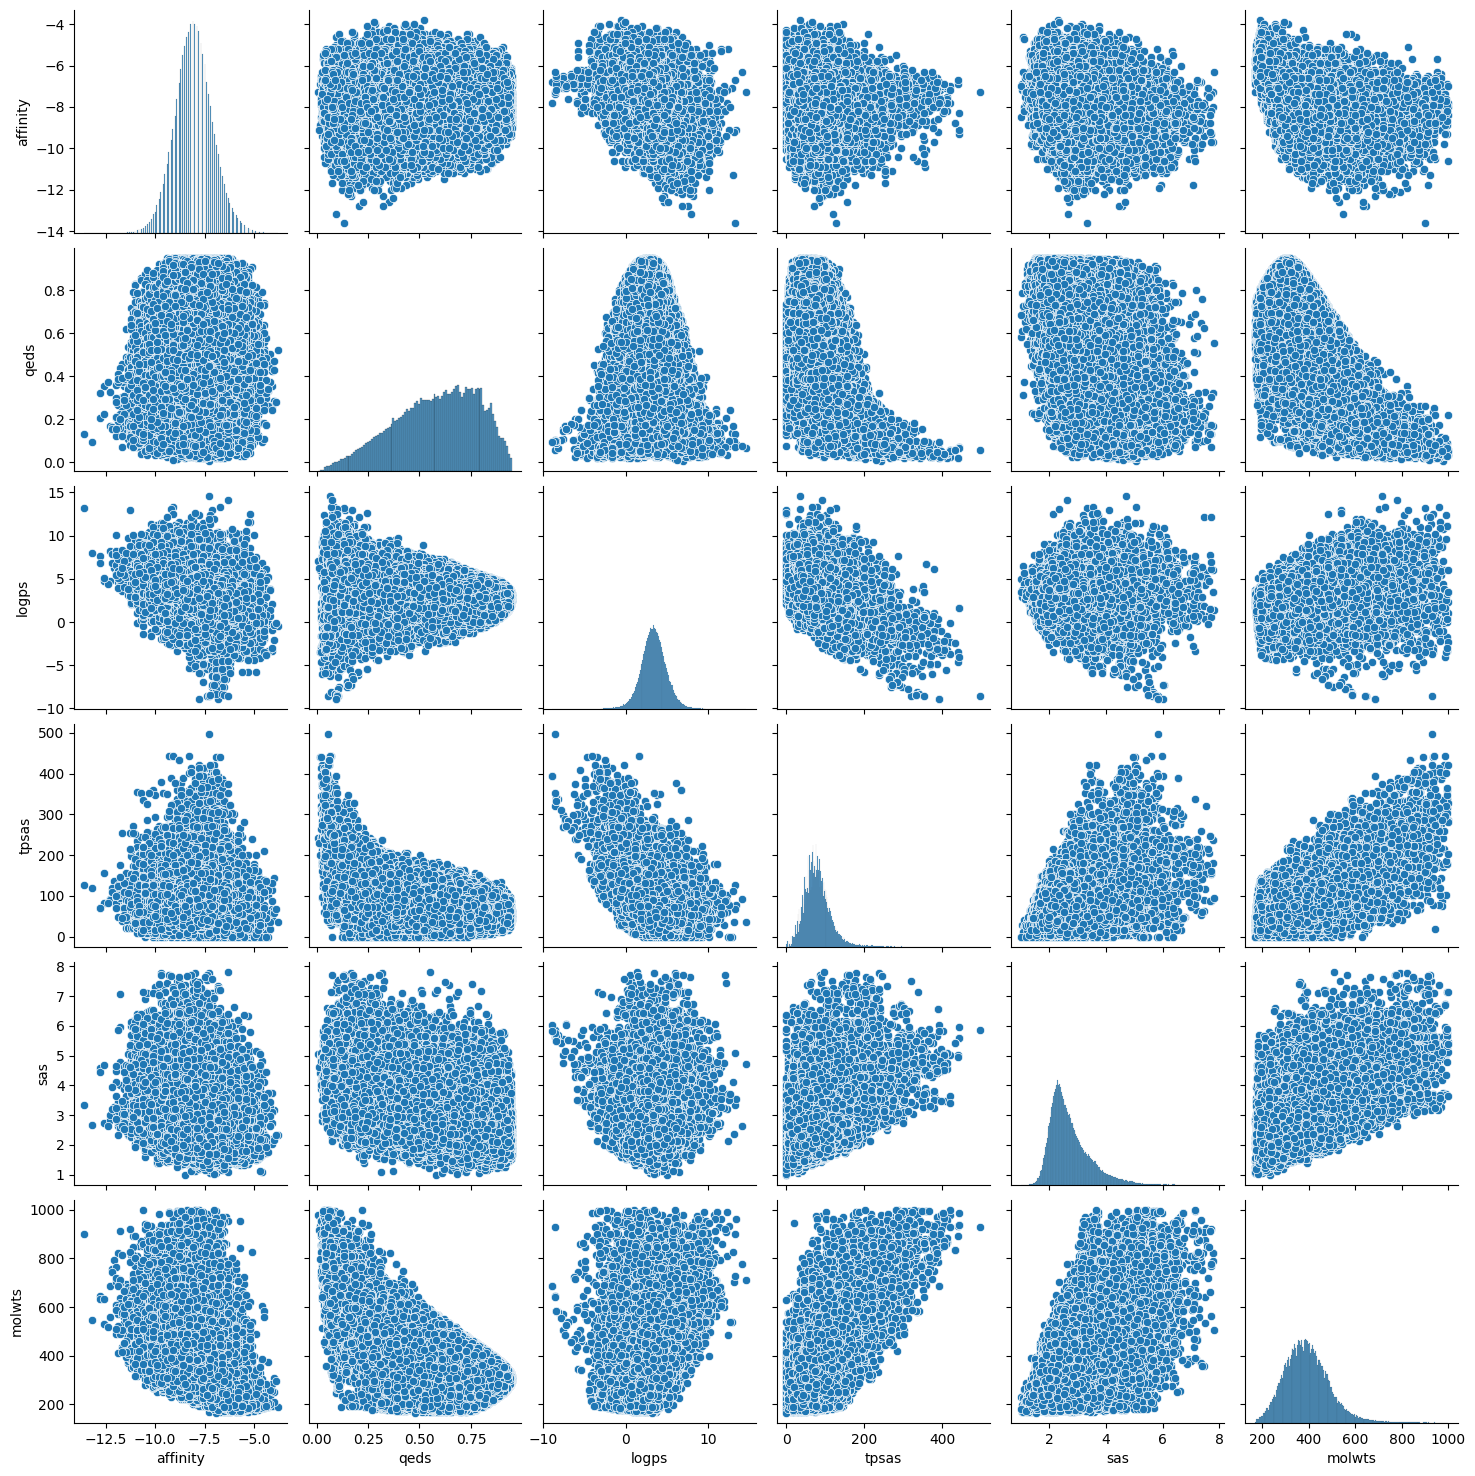

In [7]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')
sns.pairplot(df)

In [8]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qeds'].values.reshape(-1,1))
logp_scaler.fit(df['logps'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsas'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qeds'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logps'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsas'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

In [9]:
SMI_MAX_SIZE= -1
with open('../data/DOCKSTRING/smiles_corpus.txt', 'w') as f:
    train = []
    test = []        
    for i, row in df.iterrows():
        if row['split'] == "test":
            test.append(list(row.values))
        else:
            train.append(list(row.values))
        f.write(split(row['smiles'] +'\n'))
        
        if SMI_MAX_SIZE < len(row['smiles']):
            SMI_MAX_SIZE = len(row['smiles'])
f.close()
print("SMI_MAX_SIZE ", SMI_MAX_SIZE)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

SMI_MAX_SIZE  241


In [10]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/DOCKSTRING/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

Building Vocab


In [11]:

class CustomTargetDataset(Dataset):
    def __init__(self, dataframe, SmilesVocab, properties_list):
        self.dataframe = dataframe
        self.smiles_vocab = SmilesVocab
        self.property_list = properties_list
        self.build()
        
    def build(self):
        smiles, properties, affinities= [],[],[]
        smiles_encoding = []
        for i, row in self.dataframe.iterrows():
            smi = row['smiles']
            # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
            newsmi = smi
            smiles.append(newsmi)
            smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
            props = []
            for p in self.property_list:
                props.append(row[p])
            properties.append(props)

        self.smiles_encodings = torch.tensor(smiles_encoding)
        self.properties = torch.tensor(properties)
        self.smiles = smiles
        # self.affinities = torch.tensor(affinities)
        print("dataset built")
        
    def __len__(self):
        return len(self.properties)
    
    def __getitem__(self, index):
        return {
            "smiles_rep": self.smiles_encodings[index],
            "properties": self.properties[index],
            "smiles":self.smiles[index]
        }

In [12]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

In [13]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

In [14]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

In [15]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))
        self.property_encoder = PropertyEncoder(d_model,n_properties=n_properties)
        
    def forward(self, x, property):
        property = self.property_encoder(property)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=property,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

In [16]:
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(data_loader):
        data = {k: v.to(device) for k, v in data.items()}
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = {k: v.to(device) for k, v in data.items()}
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)


In [17]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)
        

In [18]:
class Sampler:
    def __init__(self, model, vocab, temperature=1.0):
        self.model = model
        self.vocab = vocab
        self.temperature = temperature
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property) / self.temperature
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples
            

In [19]:

# def run(config):
#     PROPERTIES = config['properties']
#     train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=PROPERTIES)
#     test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=PROPERTIES)
    
#     batch_size = config['batch_size'] # Define your batch size
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
#     data = next(iter(train_loader))
 
#     model = SmileDecoder(d_model=config['d_model'], 
#                    n_heads=config['n_heads'], 
#                    n_layers=config['n_layers'], 
#                    vocab=smiles_vocab, 
#                    n_properties=len(PROPERTIES), 
#                    hidden_units=config['hidden_units'],
#                    dropout=0.1)
    
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
#     model.to(device)
#     num_gpus = torch.cuda.device_count()
#     print("No of GPUs available", num_gpus)

#     model = torch.nn.parallel.DataParallel(model)
    
#     tl = []
#     vl = []
    

#     wandb.init(project="molgpt2.0 Decoder DOCKSTRING", config=config, name=config['run_name'])
#     wandb.watch(models=model, log_freq=100)
#     print(config)

#     sampler = Sampler(model, smiles_vocab)
#     All_samples = []
#     for i in range(config['epochs']):
        
#         train_loss = train_step(model, train_loader, optimizer,i)
#         val_loss = val_step(model, test_loader, i)
#         tl.append(train_loss)
#         vl.append(val_loss)
#         wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=i)
#         save_model(model, config)
        
#         if i % 10 == 0:
#             with torch.no_grad():
#                 samples = sample_a_bunch(model, test_loader,greedy=False)
#                 try:
#                     img = Draw.MolsToGridImage([MolFromSmiles(i) for i in samples[:10]],returnPNG=False,molsPerRow=10)
#                     wandb.log({"Generated Mols": wandb.Image(img)}, step=i)
#                 except:
#                     print("couldnt generate Image of samples")
            
#                 df = pd.DataFrame({"SMILES":samples})
#                 df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')
                
            
        
        

In [20]:
config = {
    'batch_size' :512,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 1024,
    'lr': 1e-6,
    'epochs': 2,
    'properties': sorted(['affinity', 'qeds', 'logps','tpsas', 'sas'])
}
config['run_name'] = "LCK_DOCKSTRING_"+ "_".join(prop for prop in config['properties'])
print(config)

{'batch_size': 512, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 1024, 'lr': 1e-06, 'epochs': 2, 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'], 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'}


In [21]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [22]:
# import pickle
# with open('../checkpoints/'+ config['run_name']+ '/PreferenceData_baff.pkl', 'rb') as f:
    # preference_data = pickle.load(f)

In [23]:
# preference_data[0]

In [24]:
# baff = []
# for row in preference_data:
    # baff.append(row[1][0])

In [25]:
# baff_scaled = affinity_scaler.inverse_transform(np.array(baff).reshape(-1,1))

In [26]:
# plt.hist(baff_scaled, bins=50)
# plt.hist(baff_scaled[:1000], bins=50)
# plt.hist(baff, bins=50)
# plt.hist(baff[:1000], bins=50)


In [24]:
# for i in range(len(baff_scaled)):
#     preference_data[i].append(baff_scaled[i])

In [27]:
print(config['run_name'])

LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas


In [28]:
import pickle
with open('../checkpoints/' + config['run_name']+'/RawPreferenceData.pkl', 'rb') as f:
    target_smiles, target_properties, sampled_smiles = pickle.load(f)
    
len(target_smiles)

41800

In [29]:
import pickle
with open('../checkpoints/' +config['run_name'] + '/PreferenceDataAffinities.pkl', 'rb') as f:
    data = pickle.load(f)
len(data)

5800

In [30]:


class PreferenceDataset(Dataset):
    def __init__(self, preference_data, vocab, property_names):
        self.preference_Data = preference_data
        self.smiles_vocab = vocab
        self.property_names = property_names
        self.build()
          
    
    def build(self):
        smiles_good, smiles_bad, properties = [],[],[]
        
        for i, row in enumerate(self.preference_Data):
            smi = row[0]
            target_props = row[1]
            good_smi = row[2][0]
            good_prop = row[2][2]
            bad_smi = row[3][0]
            bad_prop = row[3][2]
            smiles_good.append(self.smiles_vocab.to_seq(split(good_smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
            smiles_bad.append(self.smiles_vocab.to_seq(split(bad_smi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
            properties.append(target_props)
            
        self.smiles_good_encodings = torch.tensor(smiles_good)
        self.smiles_bad_encodings = torch.tensor(smiles_bad)
        self.properties = torch.tensor(properties, dtype=torch.float32)
        print("dataset built")
        
    def __len__(self):
        return len(self.properties)
    
    def __getitem__(self, index):
        return {
            "smiles_good": self.smiles_good_encodings[index],
            "smiles_bad": self.smiles_bad_encodings[index],
            "properties": self.properties[index]
        }

In [31]:
def preference_loss(policy_chosen_logps: torch.FloatTensor,
                    policy_rejected_logps: torch.FloatTensor,
                    reference_chosen_logps: torch.FloatTensor,
                    reference_rejected_logps: torch.FloatTensor,
                    beta,
                    label_smoothing: float = 0.1,
                    ipo: bool = False
                    ):
  
    pi_logratios = policy_chosen_logps - policy_rejected_logps
    ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios - ref_logratios  # also known as h_{\pi_\theta}^{y_w,y_l}

    if ipo:
        losses = (logits - 1/(2 * beta)) ** 2  # Eq. 17 of https://arxiv.org/pdf/2310.12036v2.pdf
    else:
        # Eq. 3 https://ericmitchell.ai/cdpo.pdf; label_smoothing=0 gives original DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
        losses = -F.logsigmoid(beta * logits) * (1 - label_smoothing) - F.logsigmoid(-beta * logits) * label_smoothing
        
    # Eq. 3 https://ericmitchell.ai/cdpo.pdf; label_smoothing=0 gives original DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    # losses = -F.logsigmoid(beta * logits) * (1 - label_smoothing) - F.logsigmoid(-beta * logits) * label_smoothing

    chosen_rewards = beta * (policy_chosen_logps - reference_chosen_logps).detach()
    rejected_rewards = beta * (policy_rejected_logps - reference_rejected_logps).detach()

    return losses, chosen_rewards, rejected_rewards


In [32]:
#-(f.log.beta.logits (1-label_smoothing) - f.log.beta.logits(label_smoothing))
# -f.log.beta.logits + f.log.beta.logits.label_smoothing + f.log.beta.logits.label_smoothing

In [33]:
def calculate_logprobs(model, smiles_rep, properties):
    
    out = model(smiles_rep, properties)
    ids = smiles_rep[:,1:]
    out = out[:,:-1,:]
    logitprobs = F.log_softmax(out, dim= -1)
    finalprobs =  logitprobs[np.arange(logitprobs.shape[0])[:,None], np.arange(logitprobs.shape[1])[None,:], ids]
    logprobs = finalprobs.sum(dim=-1)
    return logprobs

In [34]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [35]:
# import nn.utils.clip_grad_value_
def train_step(model, ref_model, data_loader, optimizer,epoch):
    # print("BETA", BETA)
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(data_loader):
        data = {k: v.to(device) for k, v in data.items()}
        
        optimizer.zero_grad()    
            
        policy_chosen_logps = calculate_logprobs(model, data['smiles_good'], data['properties'])
        policy_rejected_logps = calculate_logprobs(model, data['smiles_bad'], data['properties'])

        reference_chosen_logps = calculate_logprobs(ref_model, data['smiles_good'], data['properties'])
        reference_rejected_logps = calculate_logprobs(ref_model, data['smiles_bad'], data['properties'])

        losses, chosen_rewards, rejected_rewards = preference_loss(policy_chosen_logps, policy_rejected_logps, reference_chosen_logps, reference_rejected_logps, beta=BETA)
        losses = losses.mean(dim=-1)
        losses.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(losses.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), losses.item() ), end='\r')
        
    return np.mean(running_loss)
        


In [36]:
# import nn.utils.clip_grad_value_
def val_step(model, ref_model, data_loader,epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = {k: v.to(device) for k, v in data.items()}
            
            policy_chosen_logps = calculate_logprobs(model, data['smiles_good'], data['properties'])
            policy_rejected_logps = calculate_logprobs(model, data['smiles_bad'], data['properties'])

            reference_chosen_logps = calculate_logprobs(ref_model, data['smiles_good'], data['properties'])
            reference_rejected_logps = calculate_logprobs(ref_model, data['smiles_bad'], data['properties'])

            losses, chosen_rewards, rejected_rewards = preference_loss(policy_chosen_logps, policy_rejected_logps, reference_chosen_logps, reference_rejected_logps, beta=BETA)
            losses = losses.mean(dim=-1)
            
            running_loss.append(losses.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), losses.item() ), end='\r')
        
    return np.mean(running_loss)



In [37]:
# print(len(preference_dataset))
# for i, data in enumerate(preference_dataset):
#     for key in data:
#         print(key, data[key].shape)
#     break

In [38]:
def sample_a_bunch(model, dataloader, greedy=False, temperature=1.0):
    sampler = Sampler(model, smiles_vocab, temperature=temperature)
    print("Temperature: ", temperature)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

In [39]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


In [40]:
import pickle

def run(config):
    PROPERTIES = config['properties']
    
    batch_size = config['batch_size'] # Define your batch size
    
    train_size = int(0.8 * len(preference_dataset))
    test_size = len(preference_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(preference_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
    
    model = load_model(config)
    ref_model=load_model(config)
    ref_model = freeze_model(ref_model)
    model.to(device)
    ref_model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    
    
    tl = []
    vl = []
    
    if config['ipo']:
        config['run_name'] = "IPO_Finetuning_BETA_" + str(config['beta'])+ "_" +config['run_name']

    else:
        config['run_name'] = "DPO_Finetuning_BETA_" + str(config['beta'])+ "_" +config['run_name']
    
    wandb.init(project="molgpt2.0 FINAL", config=config, name=config['run_name'])
    wandb.watch(models=model, log_freq=100)
    print(config)

    sampler = Sampler(model, smiles_vocab)
    All_samples = []
    og_test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])
    og_test_loader = DataLoader(og_test_dataset, batch_size=1024, shuffle=True, num_workers=12)
    for i in range(config['epochs']):
        
        if i % 10 == 0:
            properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, og_test_loader, greedy=False, temperature=0.5)
            results = compute_metrics([], test_SMILES, pred_SMILES)
            print(results)
            for key in results:
                wandb.log({key: results[key]}, step=i)
                
        train_loss = train_step(model,ref_model, train_loader, optimizer,i)
        val_loss = val_step(model,ref_model, test_loader, i)
        
        tl.append(train_loss)
        vl.append(val_loss)
        wandb.log({"train_loss": train_loss, "val_loss":val_loss}, step=i)
        
        save_model(model, config)
        
        
                
        # if i % 10 == 0:
        #     with torch.no_grad():
        #         samples = sample_a_bunch(model, test_loader,greedy=False)
        #         try:
        #             img = Draw.MolsToGridImage([MolFromSmiles(i) for i in samples[:10]],returnPNG=False,molsPerRow=10)
        #             wandb.log({"Generated Mols": wandb.Image(img)}, step=i)
        #         except:
        #             print("couldnt generate Image of samples")
            
        #         df = pd.DataFrame({"SMILES":samples})
        #         df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.txt')
        

In [41]:
print(config['run_name'])
import pickle
with open('../checkpoints/'+ config['run_name']+ '/PreferenceData_all.pkl', 'rb') as f:
    preference_data = pickle.load(f)
preference_dataset = PreferenceDataset(preference_data, smiles_vocab, property_names=config['properties'])

LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas
dataset built


/tmp/ipykernel_43673/1522099376.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673730874951/work/torch/csrc/utils/tensor_new.cpp:230.)
  self.properties = torch.tensor(properties, dtype=torch.float32)


In [42]:
BETA = 0.11

config = {
    'batch_size' :128,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 1024,
    'lr': 1e-6,
    'epochs': 10,
    'properties': sorted(['affinity', 'sas', 'logps', 'tpsas', 'qeds']),
    'ipo':True
}
config['run_name'] = "LCK_DOCKSTRING_"+ "_".join(prop for prop in config['properties'])
config['beta'] = BETA

config



{'batch_size': 128,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 6,
 'hidden_units': 1024,
 'lr': 1e-06,
 'epochs': 10,
 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'],
 'ipo': True,
 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas',
 'beta': 0.11}

In [43]:
# run(config)

In [44]:
# config['run_name'] = "DPO_Finetuning_BETA_" + str(config['beta'])+ "_" +config['run_name']
# config['run_name'] = "EGFR_Decoder_affinity_logps_qeds_tpsas"

In [45]:
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True, num_workers=12)

dataset built


In [46]:
config

{'batch_size': 128,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 6,
 'hidden_units': 1024,
 'lr': 1e-06,
 'epochs': 10,
 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'],
 'ipo': True,
 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas',
 'beta': 0.11}

In [47]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

In [48]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [49]:
config

{'batch_size': 128,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 6,
 'hidden_units': 1024,
 'lr': 1e-06,
 'epochs': 10,
 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'],
 'ipo': True,
 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas',
 'beta': 0.11}

In [50]:
config['run_name'] = 'DPO_Finetuning_BETA_0.1_LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'
model = load_model(config)

No of GPUs available 2


In [51]:
torch.cuda.is_available()

True

In [52]:
# properties, samples = sample_a_bunch(model, test_loader)
properties, pred_SMILES, test_SMILES  = sample_a_bunch(model, test_loader, greedy=False, temperature=0.5)
results = compute_metrics([], test_SMILES, pred_SMILES)
print(results)

Temperature:  0.5
{'Validity': 0.8447265625, 'Novelty': 1.0, 'Uniqueness': 1.0}


In [50]:
data =  next(iter(test_loader))
print(data.keys())

dict_keys(['smiles_rep', 'properties', 'smiles'])


In [51]:
# df = pd.DataFrame({"SMILES":samples})
# properties = np.array(properties)
# for i, property_name in enumerate(config['properties']):
#     df["input_" + property_name] = properties[:,i]

# df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.csv')

In [52]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [53]:
# print("validity rate", calculate_validity_rate(samples))

In [54]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, pred_SMILES)

In [55]:
print(config['properties'])

['affinity', 'logps', 'qeds', 'sas', 'tpsas']


In [56]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_tpsa = og_props[:,4]

In [57]:
import seaborn as sns


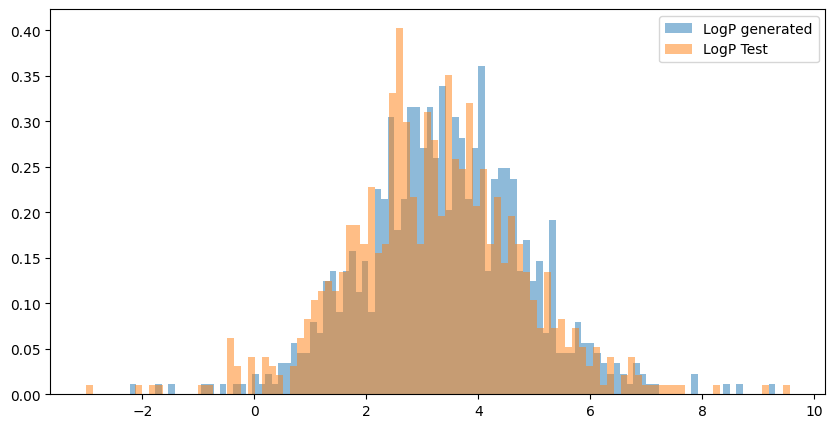

In [58]:
# histogram density plot using matplotlib
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

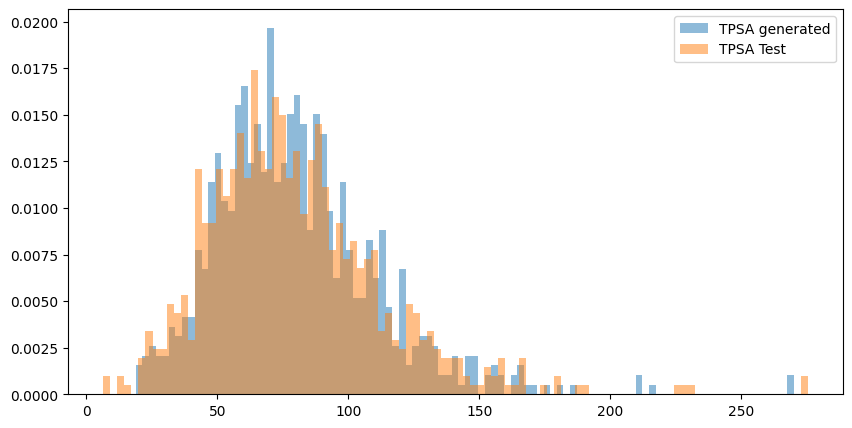

In [59]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

In [60]:
# stats = pd.DataFrame({
#                     #   "SAS_pred":sas, 
#                     #   "QED_pred":qeds, 
#                       "LogP_pred":logps, 
#                     #   "molwt_pred":molwt, 
#                       "TPSA_pred":tpsas})
# # stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
# # stats['QED_og'] = qed_scaler.inverse_transform(og_qed.reshape(-1,1)).flatten()
# stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# # stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
# stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

In [61]:
# sns.pairplot(stats)

In [62]:
target_props = {}
target_props['affinity'] = [-10, -9, -8, -7, -6]
target_props['logp'] = [3,5]
# target_props['molwt'] = [280, 320]
target_props['qed'] = [0.3, 0.8]
target_props['tpsa'] = [30, 80]
target_props['sas'] = [2, 4]

In [63]:
queries = []
property_vectors = []
for a in target_props['affinity']:
    for b in target_props['logp']:
        for c in target_props['qed']:
            for d in target_props['sas']:
                for e in target_props['tpsa']:
                    
                    key = str(a)+'-'+str(b)+'-'+str(c) + '-' + str(d) + '-' + str(e)
                    t = torch.Tensor([
                        affinity_scaler.transform([[a]]).flatten()[0],
                        logp_scaler.transform([[b]]).flatten()[0],
                        qed_scaler.transform([[c]]).flatten()[0],
                        sas_scaler.transform([[d]]).flatten()[0],
                        tpsas_scaler.transform([[e]]).flatten()[0]
                        ])
                    queries.append(key)
                    property_vectors.append(t)
property_vectors = torch.stack(property_vectors, dim=0)

In [64]:
sampler = Sampler(model, smiles_vocab, temperature=0.5)

In [65]:
property_vectors

tensor([[0.3673, 0.5065, 0.3106, 0.1468, 0.0603],
        [0.3673, 0.5065, 0.3106, 0.1468, 0.1609],
        [0.3673, 0.5065, 0.3106, 0.4405, 0.0603],
        [0.3673, 0.5065, 0.3106, 0.4405, 0.1609],
        [0.3673, 0.5065, 0.8424, 0.1468, 0.0603],
        [0.3673, 0.5065, 0.8424, 0.1468, 0.1609],
        [0.3673, 0.5065, 0.8424, 0.4405, 0.0603],
        [0.3673, 0.5065, 0.8424, 0.4405, 0.1609],
        [0.3673, 0.5918, 0.3106, 0.1468, 0.0603],
        [0.3673, 0.5918, 0.3106, 0.1468, 0.1609],
        [0.3673, 0.5918, 0.3106, 0.4405, 0.0603],
        [0.3673, 0.5918, 0.3106, 0.4405, 0.1609],
        [0.3673, 0.5918, 0.8424, 0.1468, 0.0603],
        [0.3673, 0.5918, 0.8424, 0.1468, 0.1609],
        [0.3673, 0.5918, 0.8424, 0.4405, 0.0603],
        [0.3673, 0.5918, 0.8424, 0.4405, 0.1609],
        [0.4694, 0.5065, 0.3106, 0.1468, 0.0603],
        [0.4694, 0.5065, 0.3106, 0.1468, 0.1609],
        [0.4694, 0.5065, 0.3106, 0.4405, 0.0603],
        [0.4694, 0.5065, 0.3106, 0.4405, 0.1609],


In [66]:
print(queries)

['-10-3-0.3-2-30', '-10-3-0.3-2-80', '-10-3-0.3-4-30', '-10-3-0.3-4-80', '-10-3-0.8-2-30', '-10-3-0.8-2-80', '-10-3-0.8-4-30', '-10-3-0.8-4-80', '-10-5-0.3-2-30', '-10-5-0.3-2-80', '-10-5-0.3-4-30', '-10-5-0.3-4-80', '-10-5-0.8-2-30', '-10-5-0.8-2-80', '-10-5-0.8-4-30', '-10-5-0.8-4-80', '-9-3-0.3-2-30', '-9-3-0.3-2-80', '-9-3-0.3-4-30', '-9-3-0.3-4-80', '-9-3-0.8-2-30', '-9-3-0.8-2-80', '-9-3-0.8-4-30', '-9-3-0.8-4-80', '-9-5-0.3-2-30', '-9-5-0.3-2-80', '-9-5-0.3-4-30', '-9-5-0.3-4-80', '-9-5-0.8-2-30', '-9-5-0.8-2-80', '-9-5-0.8-4-30', '-9-5-0.8-4-80', '-8-3-0.3-2-30', '-8-3-0.3-2-80', '-8-3-0.3-4-30', '-8-3-0.3-4-80', '-8-3-0.8-2-30', '-8-3-0.8-2-80', '-8-3-0.8-4-30', '-8-3-0.8-4-80', '-8-5-0.3-2-30', '-8-5-0.3-2-80', '-8-5-0.3-4-30', '-8-5-0.3-4-80', '-8-5-0.8-2-30', '-8-5-0.8-2-80', '-8-5-0.8-4-30', '-8-5-0.8-4-80', '-7-3-0.3-2-30', '-7-3-0.3-2-80', '-7-3-0.3-4-30', '-7-3-0.3-4-80', '-7-3-0.8-2-30', '-7-3-0.8-2-80', '-7-3-0.8-4-30', '-7-3-0.8-4-80', '-7-5-0.3-2-30', '-7-5-0.3-2-80

In [67]:
results = {}
count = 0
for key, v in zip(queries, property_vectors):
    print(key, v)
    p = v.repeat(config['batch_size'], 1)
    samples = sampler.sample(p, greedy=False)
    if key in results:
        print("duplicate key", key)
    qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
    # results[key] = [logps, tpsas, qeds, samples]
    results[key] = [logps, qeds, sas, tpsas, samples]

    count += 1

-10-3-0.3-2-30 tensor([0.3673, 0.5065, 0.3106, 0.1468, 0.0603])


-10-3-0.3-2-80 tensor([0.3673, 0.5065, 0.3106, 0.1468, 0.1609])
-10-3-0.3-4-30 tensor([0.3673, 0.5065, 0.3106, 0.4405, 0.0603])
-10-3-0.3-4-80 tensor([0.3673, 0.5065, 0.3106, 0.4405, 0.1609])
-10-3-0.8-2-30 tensor([0.3673, 0.5065, 0.8424, 0.1468, 0.0603])
-10-3-0.8-2-80 tensor([0.3673, 0.5065, 0.8424, 0.1468, 0.1609])
-10-3-0.8-4-30 tensor([0.3673, 0.5065, 0.8424, 0.4405, 0.0603])
-10-3-0.8-4-80 tensor([0.3673, 0.5065, 0.8424, 0.4405, 0.1609])
-10-5-0.3-2-30 tensor([0.3673, 0.5918, 0.3106, 0.1468, 0.0603])
-10-5-0.3-2-80 tensor([0.3673, 0.5918, 0.3106, 0.1468, 0.1609])
-10-5-0.3-4-30 tensor([0.3673, 0.5918, 0.3106, 0.4405, 0.0603])
-10-5-0.3-4-80 tensor([0.3673, 0.5918, 0.3106, 0.4405, 0.1609])
-10-5-0.8-2-30 tensor([0.3673, 0.5918, 0.8424, 0.1468, 0.0603])
-10-5-0.8-2-80 tensor([0.3673, 0.5918, 0.8424, 0.1468, 0.1609])
-10-5-0.8-4-30 tensor([0.3673, 0.5918, 0.8424, 0.4405, 0.0603])
-10-5-0.8-4-80 tensor([0.3673, 0.5918, 0.8424, 0.4405, 0.1609])
-9-3-0.3-2-30 tensor([0.4694, 0.5065, 0.

In [68]:
config['run_name']

'IPO_Finetuning_BETA_0.11_LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'

In [69]:
import pickle
import pandas as pd
# dump results dictionary into a pickle file
with open('../checkpoints/' + config['run_name'] + '/results.pkl', 'wb') as f:
    pickle.dump(results, f)

# with open('../checkpoints/' + config['run_name'] + '/results.pkl', 'rb') as f:
#     results = pickle.load(f)

In [70]:
data = []
columns = ['Target LogP', 'Target QED', 'Target SAS', 'Target TPSA', 'Predicted LogP','Predicted QED' ,'Predicted SAS','Predicted TPSA', 'key']
for key in results:
    keys = key.split('-')
    affinity = keys[1]
    logp = keys[2]
    qed = keys[3]
    sas = keys[4]
    tpsa = keys[5]
    for i in range(len(results[key][0])):
        data.append([logp, qed, sas, tpsa, results[key][0][i], results[key][1][i], results[key][2][i], results[key][3][i], key])

In [71]:
data_df = pd.DataFrame(data, columns=columns)

In [72]:
data_df

,Target LogP,Target QED,Target SAS,Target TPSA,Predicted LogP,Predicted QED,Predicted SAS,Predicted TPSA,key
0,3,0.3,2,30,4.17760,0.556272,2.226042,34.89,-10-3-0.3-2-30
1,3,0.3,2,30,4.10570,0.318273,2.209478,34.37,-10-3-0.3-2-30
2,3,0.3,2,30,4.03932,0.585219,2.642115,39.07,-10-3-0.3-2-30
3,3,0.3,2,30,4.45720,0.461504,2.627776,35.91,-10-3-0.3-2-30
4,3,0.3,2,30,3.80130,0.446795,2.676733,38.78,-10-3-0.3-2-30
...,...,...,...,...,...,...,...,...,...
7338,5,0.8,4,80,5.11398,0.660043,4.562928,59.32,-6-5-0.8-4-80
7339,5,0.8,4,80,4.16370,0.751409,4.620981,73.91,-6-5-0.8-4-80
7340,5,0.8,4,80,5.50348,0.672732,3.597665,65.78,-6-5-0.8-4-80
7341,5,0.8,4,80,4.25976,0.802033,4.548428,89.82,-6-5-0.8-4-80


<AxesSubplot: xlabel='Predicted TPSA', ylabel='Density'>

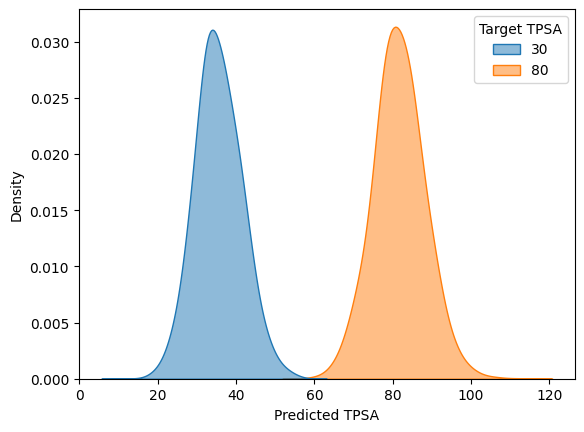

In [73]:
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)

<AxesSubplot: xlabel='Predicted LogP', ylabel='Density'>

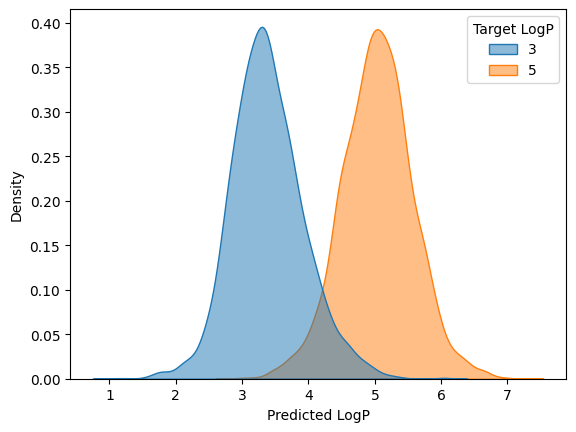

In [74]:
sns.kdeplot(data=data_df, x="Predicted LogP",hue="Target LogP", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted QED', ylabel='Density'>

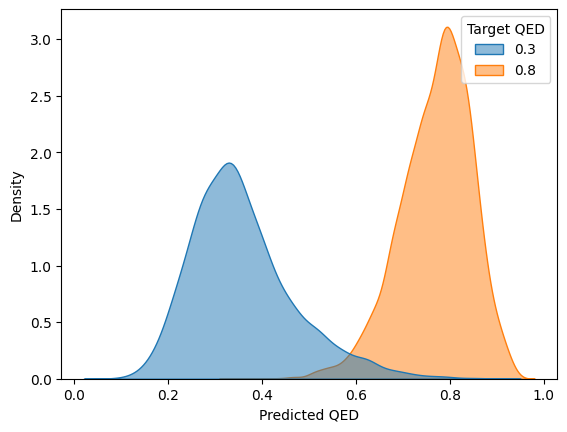

In [75]:
sns.kdeplot(data=data_df, x="Predicted QED",hue="Target QED", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted SAS', ylabel='Density'>

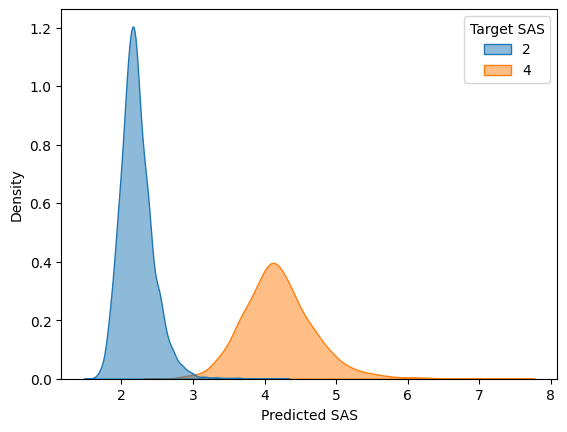

In [76]:
sns.kdeplot(data=data_df, x="Predicted SAS",hue="Target SAS", fill=True,alpha=.5, linewidth=1)

In [77]:
# len(queries)